----

# **Prophet - Forecasting**


----

## **1. Imports**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler, normalize
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import pickle
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


## **2. Load and read file**

In [3]:
df_inputx = pd.read_csv("logs.csv")
df_inputx.head()

,SOURCE_HB_TS,EXTRACT,EXTRACT_LAG,DATA_PUMP,DATA_PUMP_READ_LAG,REPLICAT,REPLICAT_READ_LAG,REPLICAT_APPLY_LAG,TOTAL_LAG
0,03-SEP-23 00:00:30.010848,EXTSPT02,3.690032,scrbgcsdk011660:9021:SPTFC02,0.512463,RSPT2,0.308204,0.773750,5.284449
1,03-SEP-23 00:00:30.010848,EXTSPT01,3.429717,scrbgcsdk011660:9021:SPTFC01,1.033683,RSPT1,0.873017,0.933534,6.269951
2,03-SEP-23 00:01:30.101339,EXTSPT01,3.314943,scrbgcsdk011660:9021:SPTFC01,1.130736,RSPT1,0.151032,0.468522,5.065233
3,03-SEP-23 00:01:30.101339,EXTSPT02,2.613914,scrbgcsdk011660:9021:SPTFC02,0.618394,RSPT2,0.965274,0.962637,5.160219
4,03-SEP-23 00:02:30.162028,EXTSPT01,2.763104,scrbgcsdk011660:9021:SPTFC01,0.548547,RSPT1,0.591709,0.953413,4.856773


In [4]:
### filter out EXTSPT01
df_input = df_inputx[df_inputx['EXTRACT']=='EXTSPT02']

In [5]:
#size of df
print("Shape of Dataframe" + str(df_input.shape))

Shape of Dataframe(44177, 9)


In [6]:
#check the data type per column
df_input.dtypes

SOURCE_HB_TS           object
EXTRACT                object
EXTRACT_LAG           float64
DATA_PUMP              object
DATA_PUMP_READ_LAG    float64
REPLICAT               object
REPLICAT_READ_LAG     float64
REPLICAT_APPLY_LAG    float64
TOTAL_LAG             float64
dtype: object

In [7]:
#review unique values
print(df_input['EXTRACT'].unique())
print(df_input['DATA_PUMP'].unique())
print(df_input['REPLICAT'].unique())

['EXTSPT02']
['scrbgcsdk011660:9021:SPTFC02']
['RSPT2']


In [8]:
#review input data
df_input.describe()

,EXTRACT_LAG,DATA_PUMP_READ_LAG,REPLICAT_READ_LAG,REPLICAT_APPLY_LAG,TOTAL_LAG
count,44177.000000,44177.000000,44177.000000,44177.000000,44177.000000
mean,4932.081139,678.649129,1799.975854,4.169799,7414.875921
std,24443.259655,5136.747446,10568.489753,35.594925,26624.114946
min,0.351406,-0.023072,-0.041631,0.003213,1.525925
25%,2.782507,0.320567,0.274421,0.294744,4.358781
50%,3.245468,0.591412,0.547537,0.568549,4.981574
75%,3.712995,0.881523,0.821584,0.842182,5.691121
max,178144.206314,59726.974641,95684.054628,1463.278786,178148.840817


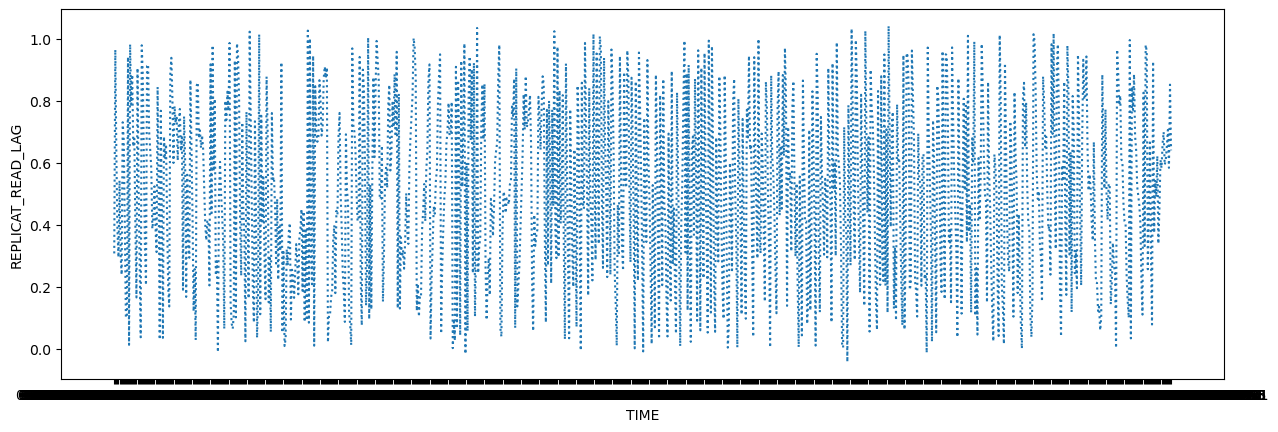

In [9]:
df_inputx = df_input.head(1000)
xpoints = df_inputx['SOURCE_HB_TS']
ypoints = df_inputx['REPLICAT_READ_LAG']

plt.figure().set_figwidth(15)
plt.plot(xpoints, ypoints, linestyle = 'dotted')
plt.xlabel('TIME')
plt.ylabel('REPLICAT_READ_LAG')

#plt.xticks(rotation=45)

# Display the plot
plt.show()

In [ ]:
df_inputx = df_input.head(10000)
xpoints = df_inputx['SOURCE_HB_TS']
ypoints = df_inputx['EXTRACT_LAG']

plt.figure().set_figwidth(15)
plt.plot(xpoints, ypoints, linestyle = 'dotted')
plt.xlabel('TIME')
plt.ylabel('EXTRACT_LAG')

#plt.xticks(rotation=45)

# Display the plot
plt.show()

In [ ]:
# df_inputx = df_input.head(10000)
# xpoints = df_inputx['SOURCE_HB_TS']
# ypoints = df_inputx['DATA_PUMP_READ_LAG']

# plt.figure().set_figwidth(15)
# plt.plot(xpoints, ypoints, linestyle = 'dotted')
# plt.xlabel('TIME')
# plt.ylabel('DATA_PUMP_READ_LAG')

# #plt.xticks(rotation=45)

# # Display the plot
# plt.show()

In [ ]:
# df_inputx = df_input.head(10000)
# xpoints = df_inputx['SOURCE_HB_TS']
# ypoints = df_inputx['REPLICAT_READ_LAG']

# plt.figure().set_figwidth(15)
# plt.plot(xpoints, ypoints, linestyle = 'dotted')
# plt.xlabel('TIME')
# plt.ylabel('REPLICAT_READ_LAG')

# #plt.xticks(rotation=45)

# # Display the plot
# plt.show()

---

# **3. Data Prep**

In [38]:
#only get 5 individual columns
df_input_kpi = df_input[['SOURCE_HB_TS', 'EXTRACT_LAG', 'DATA_PUMP_READ_LAG', 'REPLICAT_READ_LAG', 'REPLICAT_APPLY_LAG', 'TOTAL_LAG']]

#convert object to datetime
df_input_kpi['SOURCE_HB_TS'] = pd.to_datetime(df_input_kpi['SOURCE_HB_TS'])
df_input_kpi.head()

/tmp/ipykernel_30880/2162793317.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input_kpi['SOURCE_HB_TS'] = pd.to_datetime(df_input_kpi['SOURCE_HB_TS'])


,SOURCE_HB_TS,EXTRACT_LAG,DATA_PUMP_READ_LAG,REPLICAT_READ_LAG,REPLICAT_APPLY_LAG,TOTAL_LAG
0,2023-09-03 00:00:30.010848,3.690032,0.512463,0.308204,0.773750,5.284449
3,2023-09-03 00:01:30.101339,2.613914,0.618394,0.965274,0.962637,5.160219
5,2023-09-03 00:02:30.162028,3.546867,0.843435,0.625958,0.084262,5.100522
7,2023-09-03 00:03:30.038897,3.657657,0.935406,0.386294,0.130581,5.109938
9,2023-09-03 00:04:30.038690,3.660945,0.852843,0.295847,0.287669,5.097304


In [40]:
#check datatime. First column should be datetime
df_input_kpi.dtypes

SOURCE_HB_TS          datetime64[ns]
EXTRACT_LAG                  float64
DATA_PUMP_READ_LAG           float64
REPLICAT_READ_LAG            float64
REPLICAT_APPLY_LAG           float64
TOTAL_LAG                    float64
dtype: object

# **4. ML models**

In [41]:
last_minutes_used_in_training = 60  #30 minutes used for training
forecast_in_minutes = 10  #10 minutes will be forecast

In [42]:
print("Dataframe ends at " + str(df_input_kpi.tail(1).SOURCE_HB_TS))

Dataframe ends at 88353   2023-10-04 06:41:30.009638
Name: SOURCE_HB_TS, dtype: datetime64[ns]


## Model 1 - FB Prophet

In [64]:
#filter on columsn and change name
df_input_extract_lag = df_input[['SOURCE_HB_TS', 'TOTAL_LAG']]

df_input_extract_lag.rename(columns={"SOURCE_HB_TS": "ds", "TOTAL_LAG":"y"}, inplace=True)
df_input_extract_lag['ds'] = pd.to_datetime(df_input_extract_lag['ds'])

#filter on X last minutes for forecast
input_prophet_1 = df_input_extract_lag.tail(last_minutes_used_in_training)
input_prophet_1['ds'] = pd.to_datetime(input_prophet_1['ds'])

m_1 = Prophet(changepoint_prior_scale=0.9, daily_seasonality=True)
m_1.fit(input_prophet_1)

/tmp/ipykernel_30880/1809637223.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input_extract_lag.rename(columns={"SOURCE_HB_TS": "ds", "TOTAL_LAG":"y"}, inplace=True)
/tmp/ipykernel_30880/1809637223.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input_extract_lag['ds'] = pd.to_datetime(df_input_extract_lag['ds'])
/tmp/ipykernel_30880/1809637223.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

In [65]:
#create a empty dataframe with forecast dates
future_1 = m_1.make_future_dataframe(periods=forecast_in_minutes, freq="min")

#use the model to predict
forecast_1 = m_1.predict(future_1)
forecast_1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
65,2023-10-04 06:47:30.009638,4.673653,3.686621,5.665103
66,2023-10-04 06:48:30.009638,4.671380,3.581392,5.639586
67,2023-10-04 06:49:30.009638,4.669488,3.654932,5.701304
68,2023-10-04 06:50:30.009638,4.667999,3.702381,5.720345
69,2023-10-04 06:51:30.009638,4.666936,3.732841,5.617089


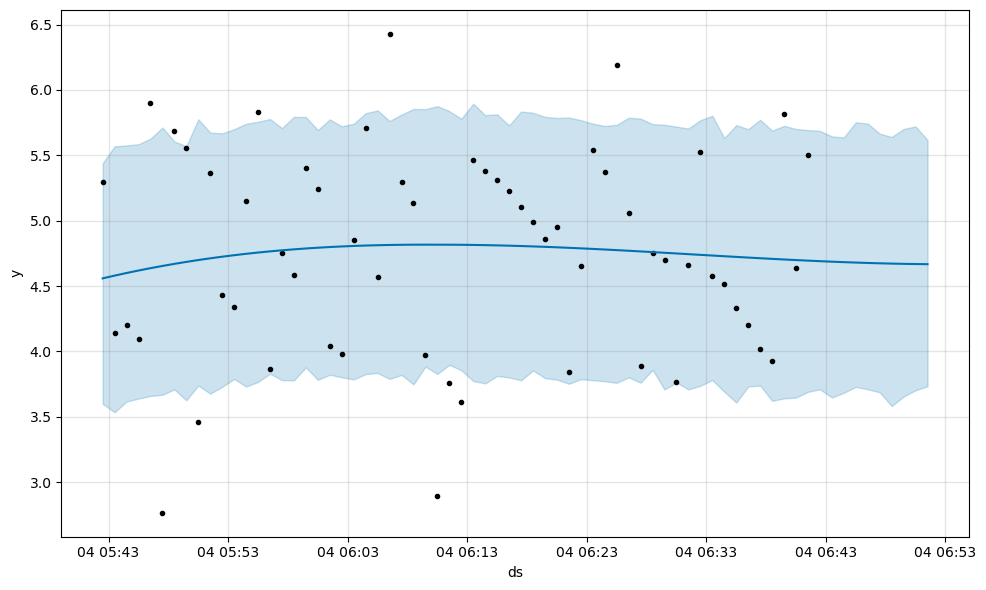

In [66]:
fig1 = m_1.plot(forecast_1)

### Use the forecast (10 minutes in the future) to see expected growth

In [46]:
## simple calculation as example

# average actual 30 minutes as input
avg_input = forecast_1['yhat'].head(30).mean()
max_input = forecast_1['yhat'].head(30).max()
min_input = forecast_1['yhat'].head(30).min()
print("Average in input value is " + str(avg_input))
print("Max input value " + str(max_input))
print("Min input value " + str(min_input))
print(" ------------------- ")
#average 10 minutes as forecasted
avg_forecast = forecast_1['yhat'].tail(10).mean()
max_forecast = forecast_1['yhat'].tail(10).max() 
min_forecast = forecast_1['yhat'].tail(10).min() 
print("Average in forecast value is " + str(avg_forecast))
print("Max forecast value " + str(max_forecast))
print("Min forecast value " + str(min_forecast))
print(" ------------------- ")

#increase/decrease based on actual vs forecasted
diff_perc_input_vs_forecast = round(((avg_forecast-avg_input)/avg_input)*100,2)
diff_perc_max = round(((max_forecast-max_input)/max_input)*100,2)
diff_perc_min = round(((min_forecast-min_input)/min_input)*100,2)
print("Expected increase or decreases in the coming 10 minutes is " + str(diff_perc_input_vs_forecast)+str("%"))
print("Expected increase/decrease in max "  + str(diff_perc_max)+str("%"))
print("Expected increase/decrease in min "  + str(diff_perc_min)+str("%"))


Average in input value is 0.5735706723936062
Max input value 0.67800615857
Min input value 0.5197300037542475
 ------------------- 
Average in forecast value is 0.5890849279689785
Max forecast value 0.6014045750201261
Min forecast value 0.5767652809178309
 ------------------- 
Expected increase or decreases in the coming 10 minutes is 2.7%
Expected increase/decrease in max -11.3%
Expected increase/decrease in min 10.97%


---

# **4. Create model artifacts**

In [ ]:
#!odsc conda init -b conda_env -n frzpemb9ufe8 -a resource_principal

In [ ]:
#!odsc conda publish -s tensorflow28_p38_cpu_v1 --force

In [ ]:
from ads.model.framework.tensorflow_model import TensorFlowModel
from ads.common.model_metadata import UseCaseType
from ads.common.model_artifact import ModelArtifact
from ads.common.model_export_util import prepare_generic_model
import os

In [ ]:
#path to artifacts and conda slug
path_to_artifacts = './model_artifacts_v2'
conda_env = 'oci://conda_env@frzpemb9ufe8/conda_environments/cpu/TensorFlow 2.8 for CPU on Python 3.8/1.0/tensorflow28_p38_cpu_v1'  

#create default artifacts
artifact = prepare_generic_model(
    path_to_artifacts, 
    fn_artifact_files_included=False, 
    force_overwrite=True, 
    inference_conda_env=conda_env)

# **5. Full code score.py**

In [173]:
#%%writefile ./model_artifacts_v2/score.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler, normalize
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import pickle
from prophet import Prophet


###########
###########
import ads
import os
import configparser
import shutil
from zipfile import ZipFile
from tempfile import NamedTemporaryFile
import urllib
import re
import sqlalchemy
from sqlalchemy import create_engine
import cx_Oracle

#make sure read/write access to wallet
os.system("chmod +rwx ./Wallet_pocdb.zip")

def create_uri(user_name, password, wallet_name, wallet_storage_directory):
    
    database_name = wallet_name
    database_user = user_name
    database_password = password
    
    wallet_storage_directory = wallet_storage_directory

    # Create the wallet directory if missing: 
    ads.set_documentation_mode(False)

    os.makedirs(wallet_storage_directory, mode=0o700, exist_ok=True)

    wallet_path = os.path.join(wallet_storage_directory, database_name)

    # Prepare to store ADB connection information
    adb_config = os.path.join(wallet_storage_directory, '.credentials')

    # Write a configuration file for login creds.
    config = configparser.ConfigParser()
    config.read(adb_config)
    config[database_name] = {'tns_admin': wallet_path,
                             'sid': '{}_medium'.format(database_name.lower()),
                             'user': database_user,
                             'password': database_password}
    with open(adb_config, 'w') as configfile:
        config.write(configfile)


    # Read in the credentials configuration files
    my_config = configparser.ConfigParser()
    my_config.read(adb_config)

    # Access a setting
    print(my_config[database_name].get('user'))

    # Limit the information to a specific database
    my_creds = my_config[database_name]
    print(my_creds.get('user'))


    # extract the wallet
    wallet_file = 'Wallet_{}.zip'.format(database_name)
    wallet_filename = os.path.join(wallet_storage_directory, wallet_file)
    if not os.path.exists(wallet_filename):
        print("The file {} does not exist.".format(wallet_filename))
        print("Please copy the Wallet file, {}, into the directory {} then rerun this cell.".format(wallet_file, wallet_filename))
    else:
        os.makedirs(wallet_path, mode=0o700, exist_ok=True)
        with ZipFile(wallet_filename, 'r') as zipObj:
            zipObj.extractall(wallet_path)


    # Update the sqlnet.ora

    sqlnet_path = os.path.join(wallet_path, 'sqlnet.ora')
    sqlnet_original_path = os.path.join(wallet_path, 'sqlnet.ora.original')
    sqlnet_backup_path = os.path.join(wallet_path, 'sqlnet.ora.backup')
    if not os.path.exists(sqlnet_original_path):
        shutil.copy(sqlnet_path, sqlnet_original_path)
    if os.path.exists(sqlnet_path):
        shutil.copy(sqlnet_path, sqlnet_backup_path)
    sqlnet_re = re.compile('(WALLET_LOCATION\s*=.*METHOD_DATA\s*=.*DIRECTORY\s*=\s*\")(.*)(\".*)', 
                           re.IGNORECASE)
    tmp = NamedTemporaryFile()
    with open(sqlnet_path, 'rt') as sqlnet:
        for line in sqlnet:
            tmp.write(bytearray(sqlnet_re.subn(r'\1{}\3'.format(wallet_path), line)[0], 
                                encoding='utf-8'))
    tmp.flush()
    shutil.copy(tmp.name, sqlnet_path)
    tmp.close()

    # Add TNS_ADMIN to the environment
    os.environ['TNS_ADMIN'] = config[database_name].get('tns_admin')

    # Test the database connection
    creds = config[database_name]
    connect = 'sqlplus ' + creds.get('user') + '/' + creds.get('password') + '@' + creds.get('sid')
    print(os.popen(connect).read())

    # Get the URI to connect to the database
    uri='oracle+cx_oracle://' + creds.get('user') + ':' + creds.get('password') + '@' + creds.get('sid')
    
    engine = create_engine(uri)

    return engine, wallet_filename

############################
############################

def load_model():
    class DummyModel:
        def __init__(self):
            pass
    return DummyModel()

############################
############################

list_to_db = []
list_variables = ['EXTRACT_LAG', 'DATA_PUMP_READ_LAG', 'REPLICAT_READ_LAG', 'REPLICAT_APPLY_LAG', 'TOTAL_LAG']

def predict(data, model=load_model()):
    
    #get the bucket name, namespace, and full file name
    file_name = data['file_name']
    bucket_name = data['bucket_name']
    namespace = data['namespace']
    
    #read the .txt file
    input_all_minutes = pd.read_csv(f"oci://{bucket_name}@{namespace}/{file_name}") 
    print("first line of data" + str(input_all_minutes.head(1)))
    
    #get the latest 60 minues only.
    input_60_minutes = input_all_minutes.tail(60)
    print(input_60_minutes.shape)
        
    #loop through the 5 variables. Build forecast for each one of them and push to database
    for variable in list_variables:
        
        print("Start variable " + variable)
        
        #only select one variable to filter on
        df_input_1_variable = input_60_minutes[['SOURCE_HB_TS', variable]]
        
        #change name to what Prophet expects       
        df_input_1_variable.rename(columns={"SOURCE_HB_TS": "ds", variable:"y"}, inplace=True)
        
        #convert ds to timeframe
        df_input_1_variable['ds'] = pd.to_datetime(df_input_1_variable['ds'])
        
        #start date
        start_date = df_input_1_variable['ds'].min()
        print("Start time of " + variable + " is " + str(start_date))

        #end date
        end_date = df_input_1_variable['ds'].max()
        print("End time of " + variable + " is " + str(end_date))

        #general settings
        forecast_in_minutes = 10  #10 minutes will be forecast

        m_1 = Prophet(changepoint_prior_scale=0.9)
        m_1.fit(df_input_1_variable)

        #create a empty dataframe with forecast dates
        future_1 = m_1.make_future_dataframe(periods=forecast_in_minutes, freq="min")

        #use the model to predict
        forecast_1 = m_1.predict(future_1)
        forecast_1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

        # average actual 60 minutes as input
        avg_input = forecast_1['yhat'].head(60).mean()
        max_input = forecast_1['yhat'].head(60).max()
        min_input = forecast_1['yhat'].head(60).min()
        print("Average in input value is " + str(avg_input))
        print("Max input value " + str(max_input))
        print("Min input value " + str(min_input))
        print(" ------------------- ")

        #average 10 minutes as forecasted
        avg_forecast = forecast_1['yhat'].tail(10).mean()
        max_forecast = forecast_1['yhat'].tail(10).max() 
        min_forecast = forecast_1['yhat'].tail(10).min() 
        print("Average in forecast value is " + str(avg_forecast))
        print("Max forecast value " + str(max_forecast))
        print("Min forecast value " + str(min_forecast))
        print(" ------------------- ")

        #increase/decrease based on actual vs forecasted
        diff_perc_avg = round(((avg_forecast-avg_input)/avg_input)*100,2)
        diff_perc_max = round(((max_forecast-max_input)/max_input)*100,2)
        diff_perc_min = round(((min_forecast-min_input)/min_input)*100,2)
        print("Expected increase or decreases in the coming 10 minutes is " + str(diff_perc_input_vs_forecast)+str("%"))
        print("Expected increase/decrease in max "  + str(diff_perc_max)+str("%"))
        print("Expected increase/decrease in min "  + str(diff_perc_min)+str("%"))


        #add to list
        list_to_db.append([variable, start_date, end_date, avg_input, max_input, min_input, avg_forecast, max_forecast, min_forecast, diff_perc_avg, diff_perc_max, diff_perc_min])
        df_to_db = pd.DataFrame(list_to_db, columns =['variable', 'start_date', 'end_date', 'avg_input', 'max_input', 'min_input','avg_forecast', 'max_forecast', 'min_forecast', 'diff_perc_avg', 'diff_perc_max', 'diff_perc_min'])

        #################
        ################ push results to adw

        #create connection
        engine, wallet_filename = create_uri("OMLUSER", "[password]", "[name_of_db]", "./")   

        ## push results to database
        df_to_db.to_sql('table_1', con=engine, index=False, if_exists="append", dtype={
                
                'variable': sqlalchemy.types.NVARCHAR(length=500),
                'start_date': sqlalchemy.types.DateTime(),
                'end_date': sqlalchemy.types.DateTime(),
                'avg_input': sqlalchemy.types.FLOAT(),
                'max_input': sqlalchemy.types.FLOAT(),
                'min_input': sqlalchemy.types.FLOAT(),
                'avg_forecast': sqlalchemy.types.FLOAT(),
                'max_forecast': sqlalchemy.types.FLOAT(),            
                'min_forecast': sqlalchemy.types.FLOAT(),            
                'diff_perc_avg': sqlalchemy.types.FLOAT(),
                'diff_perc_max': sqlalchemy.types.FLOAT(),
                'diff_perc_min': sqlalchemy.types.FLOAT()})

        print()
        print("-----------------------")
        print("Table updated with results for " + variable)
        print("-----------------------")
    
    
    #return {'diff_perc_input_vs_forecast':diff_perc_input_vs_forecast, 'avg_input':avg_input, 'avg_forecast':avg_forecast}

# **6. Test the full code with JSON as input**

In [174]:
# #example input

data = {'file_name':'logs.csv', 'bucket_name':'LagMetricFiles', 'namespace':'frzpemb9ufe8'}


In [175]:
predict(data)

13:36:34 - cmdstanpy - INFO - Chain [1] start processing
13:36:34 - cmdstanpy - INFO - Chain [1] done processing


first line of data                SOURCE_HB_TS   EXTRACT  EXTRACT_LAG  \
0  03-SEP-23 00:00:30.010848  EXTSPT02     3.690032   

                      DATA_PUMP  DATA_PUMP_READ_LAG REPLICAT  \
0  scrbgcsdk011660:9021:SPTFC02            0.512463    RSPT2   

   REPLICAT_READ_LAG  REPLICAT_APPLY_LAG  TOTAL_LAG  
0           0.308204             0.77375   5.284449  
(140, 9)
Start variable EXTRACT_LAG
Start time of EXTRACT_LAG is 2023-10-04 05:32:30.038729
End time of EXTRACT_LAG is 2023-10-04 06:41:30.009638
Average in input value is 3.0793583239400504
Max input value 3.150009574150427
Min input value 2.9267020306054685
 ------------------- 
Average in forecast value is 3.046255451343172
Max forecast value 3.0616686722464017
Min forecast value 3.030842230439943
 ------------------- 
Expected increase or decreases in the coming 10 minutes is 2.7%
Expected increase/decrease in max -2.8%
Expected increase/decrease in min 3.56%
OMLUSER
OMLUSER


13:36:35 - cmdstanpy - INFO - Chain [1] start processing
13:36:35 - cmdstanpy - INFO - Chain [1] done processing



SQL*Plus: Release 19.0.0.0.0 - Production on Mon Oct 16 13:36:34 2023
Version 19.17.0.0.0

Copyright (c) 1982, 2022, Oracle.  All rights reserved.

Last Successful login time: Mon Oct 16 2023 13:35:26 +00:00

Connected to:
Oracle Database 19c Enterprise Edition Release 19.0.0.0.0 - Production
Version 19.21.0.1.0

SQL> Disconnected from Oracle Database 19c Enterprise Edition Release 19.0.0.0.0 - Production
Version 19.21.0.1.0


-----------------------
Table updated with results for EXTRACT_LAG
-----------------------
Start variable DATA_PUMP_READ_LAG
Start time of DATA_PUMP_READ_LAG is 2023-10-04 05:32:30.038729
End time of DATA_PUMP_READ_LAG is 2023-10-04 06:41:30.009638
Average in input value is 0.6208809326947037
Max input value 0.635670643227
Min input value 0.6153599286832571
 ------------------- 
Average in forecast value is 0.6304480440440826
Max forecast value 0.6317097135323355
Min forecast value 0.6291863745558297
 ------------------- 
Expected increase or decreases in the co

13:36:35 - cmdstanpy - INFO - Chain [1] start processing
13:36:35 - cmdstanpy - INFO - Chain [1] done processing



-----------------------
Table updated with results for DATA_PUMP_READ_LAG
-----------------------
Start variable REPLICAT_READ_LAG
Start time of REPLICAT_READ_LAG is 2023-10-04 05:32:30.038729
End time of REPLICAT_READ_LAG is 2023-10-04 06:41:30.009638
Average in input value is 0.5007722228059154
Max input value 0.5209818705136703
Min input value 0.48108120907999996
 ------------------- 
Average in forecast value is 0.5121361710238392
Max forecast value 0.5177235203336737
Min forecast value 0.5065488217140047
 ------------------- 
Expected increase or decreases in the coming 10 minutes is 2.7%
Expected increase/decrease in max -0.63%
Expected increase/decrease in min 5.29%
OMLUSER
OMLUSER

SQL*Plus: Release 19.0.0.0.0 - Production on Mon Oct 16 13:36:35 2023
Version 19.17.0.0.0

Copyright (c) 1982, 2022, Oracle.  All rights reserved.

Last Successful login time: Mon Oct 16 2023 13:36:35 +00:00

Connected to:
Oracle Database 19c Enterprise Edition Release 19.0.0.0.0 - Production
Versio

13:36:36 - cmdstanpy - INFO - Chain [1] start processing
13:36:36 - cmdstanpy - INFO - Chain [1] done processing



-----------------------
Table updated with results for REPLICAT_READ_LAG
-----------------------
Start variable REPLICAT_APPLY_LAG
Start time of REPLICAT_APPLY_LAG is 2023-10-04 05:32:30.038729
End time of REPLICAT_APPLY_LAG is 2023-10-04 06:41:30.009638
Average in input value is 0.5440999588299271
Max input value 0.5583518153206204
Min input value 0.53466364964
 ------------------- 
Average in forecast value is 0.566822701278579
Max forecast value 0.5692820655704529
Min forecast value 0.5643633369867052
 ------------------- 
Expected increase or decreases in the coming 10 minutes is 2.7%
Expected increase/decrease in max 1.96%
Expected increase/decrease in min 5.55%
OMLUSER
OMLUSER


13:36:37 - cmdstanpy - INFO - Chain [1] start processing
13:36:37 - cmdstanpy - INFO - Chain [1] done processing



SQL*Plus: Release 19.0.0.0.0 - Production on Mon Oct 16 13:36:37 2023
Version 19.17.0.0.0

Copyright (c) 1982, 2022, Oracle.  All rights reserved.

Last Successful login time: Mon Oct 16 2023 13:36:36 +00:00

Connected to:
Oracle Database 19c Enterprise Edition Release 19.0.0.0.0 - Production
Version 19.21.0.1.0

SQL> Disconnected from Oracle Database 19c Enterprise Edition Release 19.0.0.0.0 - Production
Version 19.21.0.1.0


-----------------------
Table updated with results for REPLICAT_APPLY_LAG
-----------------------
Start variable TOTAL_LAG
Start time of TOTAL_LAG is 2023-10-04 05:32:30.038729
End time of TOTAL_LAG is 2023-10-04 06:41:30.009638
Average in input value is 4.743504262599467
Max input value 4.866180668260095
Min input value 4.533951080524232
 ------------------- 
Average in forecast value is 4.773219030279013
Max forecast value 4.775527705532134
Min forecast value 4.770910355025892
 ------------------- 
Expected increase or decreases in the coming 10 minutes is 2.7

In [ ]:
#all should be passed
artifact.introspect()

In [ ]:
# Saving the model artifact to the model catalog. 
import ads
ads.set_auth(auth='resource_principal')

catalog_entry = artifact.save(display_name='xxx', description='xxxx', timeout=600)
catalog_entry.id

# **7. Deploy ML Model**

# **8. Test Deployed ML Model - Version 1**

In [145]:
import requests
import oci
from oci.signer import Signer
import json


In [146]:
%%time
url = "https://modeldeployment.eu-frankfurt-1.oci.customer-oci.com/ocid1.datasciencemodeldeployment.oc1.eu-frankfurt-1.amaaaaaapixtsjiaevm3vjjcyfxf2xr2k5ecrfobeo5eog5v2exoli7r4o3q/predict"

auth = oci.auth.signers.get_resource_principals_signer()

#POST request to the model
response = requests.post(url, json=data, auth=auth)
print(response)
print(json.loads(response.content))

full_response = json.loads(response.content)

<Response [500]>
{"code": "InternalServerError", "message": "Invalid file path or buffer object type: <class 'dict'>", "status": "Invalid file path or buffer object type: <class 'dict'>"}
CPU times: user 61.3 ms, sys: 1.85 ms, total: 63.2 ms
Wall time: 116 ms


## **Multiple requests - Version 1**

In [ ]:
#example input
import time
df_input_extract_lag = df_input[['SOURCE_HB_TS', 'REPLICAT_APPLY_LAG']]
df_input_extract_lag.rename(columns={"SOURCE_HB_TS": "ds", "REPLICAT_APPLY_LAG":"y"}, inplace=True)

rotations = [40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]

for setx in rotations:
    #set of 30 minutes
    input_prophet_1 = df_input_extract_lag[setx:setx+30]  #last 30 minutes, like: 40 - 70, 41 - 71, etc
    
    #convert to json
    data = input_prophet_1.to_json()
    
    url = "https://modeldeployment.eu-frankfurt-1.oci.customer-oci.com/ocid1.datasciencemodeldeployment.oc1.eu-frankfurt-1.amaaaaaapixtsjiaevm3vjjcyfxf2xr2k5ecrfobeo5eog5v2exoli7r4o3q/predict"

    auth = oci.auth.signers.get_resource_principals_signer()

    #POST request to the model
    response = requests.post(url, json=data, auth=auth)
    full_response = json.loads(response.content)
    print()
    print("XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX")
    print("Set number is " + str(setx))
    print("**Predicted increase or decrease in the coming 10 minutes = **" +str(full_response['diff_perc_input_vs_forecast']))
    print("Average number last 30 minutes = " + str(full_response['avg_input']))
    print("Average forecasted number future 10 minutes = " + str(full_response['avg_forecast']))
    print("XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX")
    print()
    time.sleep(2)



## **Multiple requests - Version 2**

In [ ]:
#example input
import time
df_input_extract_lag = df_input[['SOURCE_HB_TS', 'REPLICAT_APPLY_LAG']]
df_input_extract_lag.rename(columns={"SOURCE_HB_TS": "ds", "REPLICAT_APPLY_LAG":"y"}, inplace=True)

rotations = [40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]

for setx in rotations:
    #set of 30 minutes
    input_prophet_1 = df_input_extract_lag[setx:setx+30]  #last 30 minutes, like: 40 - 70, 41 - 71, etc
    
    #convert to json
    data = input_prophet_1.to_json()
    
    url = "https://modeldeployment.eu-frankfurt-1.oci.customer-oci.com/ocid1.datasciencemodeldeployment.oc1.eu-frankfurt-1.amaaaaaapixtsjian3qrkhcw5wazrbquy7nbovnqnrzi2cpr45ikbseywr6a/predict"

    auth = oci.auth.signers.get_resource_principals_signer()

    #POST request to the model
    response = requests.post(url, json=data, auth=auth)
    full_response = json.loads(response.content)
    print()
    print("XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX")
    print("Set number is " + str(setx))
    print("**Predicted increase or decrease in the coming 10 minutes = **" +str(full_response['diff_perc_input_vs_forecast']))
    print("Average number last 30 minutes = " + str(full_response['avg_input']))
    print("Average forecasted number future 10 minutes = " + str(full_response['avg_forecast']))
    print("XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX")
    print()
    time.sleep(3)

# **Python script in Function**

In [143]:
import oci
from datetime import datetime, timezone
config = oci.config.from_file()

# Initialize service client with default config file
object_storage_client = oci.object_storage.ObjectStorageClient(config)
# auth = oci.auth.signers.get_resource_principals_signer()

bucket_name = "LagMetricFiles"
namespace = "frzpemb9ufe8"

#object storage api to list all files in the bucket
list_objects_response = object_storage_client.list_objects(
    namespace_name=namespace,
    bucket_name=bucket_name,
    fields='name,timeCreated,timeModified')

# Get the data from response
objects = list_objects_response.data

#get the creation date for each file and get the latest file name
list_of_dates = []

for rowx in objects.objects:
    
    name = [rowx][0].name
    time_created = [rowx][0].time_created
    list_of_dates.append([name, time_created])

latest_file = max(list_of_dates)
latest_file_name = latest_file[0]
print("Latest file name is " + latest_file_name)

#cal the HTTP endpoint

data = {'file_name':latest_file_name, 'bucket_name':bucket_name, 'namespace':namespace}

url = "https://modeldeployment.eu-frankfurt-1.oci.customer-oci.com/ocid1.datasciencemodeldeployment.oc1.eu-frankfurt-1.amaaaaaapixtsjian3qrkhcw5wazrbquy7nbovnqnrzi2cpr45ikbseywr6a/predict"

response = requests.post(url, json=data, auth=auth)
print(full_response = json.loads(response.content))


Latest file name is LagMetrics/ocid1.serviceconnector.oc1.eu-frankfurt-1.amaaaaaapixtsjiarpunoxhi6tvcw3jdbgwyt6xzv4cl4zryhuigxesyyjmq/20231011T074209Z_20231011T074424Z.0.log.gz
